# Data Mining Lab 1 on New Dataset

陳奕君 111062610

This file contains the second part of HW1 (30%), which includes applying the process from Lab-1-Master to Sentiment Labelled Sentences Dataset.

In [2]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA
from sklearn.preprocessing import binarize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import math
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import helpers.data_mining_helpers as dmh

%matplotlib inline

## 1. Data Source

In [3]:
PATH = "../sentiment_labelled_sentences/"
dataset = {
    "amazon": "amazon_cells_labelled.txt",
    "imdb": "imdb_labelled.txt",
    "yelp": "yelp_labelled.txt"
}

## 2. Data Preparation

In [4]:
# Read all the sentences and label to data_dict
data_dict = {}
i = 0

# Read Amazon dataset
with open (PATH + dataset["amazon"]) as f:
    r = f.readlines()

for line in r:
    element = line.split('\n')[0].split('\t') # Split it to `text` and `label`
    element[1] = int(element[1]) # turn the label to int value
    data_dict[i] = element
    i += 1

# Read IMDB dataset
with open (PATH + dataset["imdb"]) as f:
    r = f.readlines()

for line in r:
    element = line.split('\n')[0].split('\t')
    element[1] = int(element[1])
    data_dict[i] = element
    i += 1

# Read YELP dataset
with open (PATH + dataset["yelp"]) as f:
    r = f.readlines()

for line in r:
    element = line.split('\n')[0].split('\t')
    element[1] = int(element[1])
    data_dict[i] = element
    i += 1

#### Exercise 1

In [5]:
for i in range(3):
    print(data_dict[i])

['So there is no way for me to plug it in here in the US unless I go by a converter.', 0]
['Good case, Excellent value.', 1]
['Great for the jawbone.', 1]


## 3. Data Transformation

### 3.1 Converting Dictionary into Pandas dataframe

In [6]:
# Convert data_dict to dataframe
df = pd.DataFrame(data_dict)

# Now every column is one data, but we want is every row is one data
# So we use the transpose function, and add the column name
df = df.T
df.columns = ["text", "label"]

df

text label
0     So there is no way for me to plug it in here i...     0
1                           Good case, Excellent value.     1
2                                Great for the jawbone.     1
3     Tied to charger for conversations lasting more...     0
4                                     The mic is great.     1
...                                                 ...   ...
2995  I think food should have flavor and texture an...     0
2996                           Appetite instantly gone.     0
2997  Overall I was not impressed and would not go b...     0
2998  The whole experience was underwhelming, and I ...     0
2999  Then, as if I hadn't wasted enough of my life ...     0

[3000 rows x 2 columns]

In [7]:
for t in df["text"][:3]:
    print(t)

So there is no way for me to plug it in here in the US unless I go by a converter.
Good case, Excellent value.
Great for the jawbone.


### 3.2 Familiarizing yourself with the Data

In [8]:
# query the last 10 records
df[-10:]

text label
2990  The refried beans that came with my meal were ...     0
2991         Spend your money and time some place else.     0
2992  A lady at the table next to us found a live gr...     0
2993            the presentation of the food was awful.     0
2994           I can't tell you how disappointed I was.     0
2995  I think food should have flavor and texture an...     0
2996                           Appetite instantly gone.     0
2997  Overall I was not impressed and would not go b...     0
2998  The whole experience was underwhelming, and I ...     0
2999  Then, as if I hadn't wasted enough of my life ...     0

In [9]:
# using loc (by label)
df.loc[:10, "text"]

0     So there is no way for me to plug it in here i...
1                           Good case, Excellent value.
2                                Great for the jawbone.
3     Tied to charger for conversations lasting more...
4                                     The mic is great.
5     I have to jiggle the plug to get it to line up...
6     If you have several dozen or several hundred c...
7           If you are Razr owner...you must have this!
8                   Needless to say, I wasted my money.
9                      What a waste of money and time!.
10                      And the sound quality is great.
Name: text, dtype: object

In [10]:
# using iloc (by index)
df.iloc[:10, 0]

0    So there is no way for me to plug it in here i...
1                          Good case, Excellent value.
2                               Great for the jawbone.
3    Tied to charger for conversations lasting more...
4                                    The mic is great.
5    I have to jiggle the plug to get it to line up...
6    If you have several dozen or several hundred c...
7          If you are Razr owner...you must have this!
8                  Needless to say, I wasted my money.
9                     What a waste of money and time!.
Name: text, dtype: object

### Exercise 2

In [85]:
# Query the records that label belongs to 0
df[df['label'] == 0]

text  label  \
0     So there is no way for me to plug it in here i...      0   
3     Tied to charger for conversations lasting more...      0   
5     I have to jiggle the plug to get it to line up...      0   
6     If you have several dozen or several hundred c...      0   
8                   Needless to say, I wasted my money.      0   
...                                                 ...    ...   
2995  I think food should have flavor and texture an...      0   
2996                           Appetite instantly gone.      0   
2997  Overall I was not impressed and would not go b...      0   
2998  The whole experience was underwhelming, and I ...      0   
2999  Then, as if I hadn't wasted enough of my life ...      0   

                                               unigrams bin_label  
0     [So, there, is, no, way, for, me, to, plug, it...       [0]  
3     [Tied, to, charger, for, conversations, lastin...       [0]  
5     [I, have, to, jiggle, the, plug, to, get, it, ...       [0]  
6     [If, you, have, several, dozen, or, several, h...       [0]  
8       [Needless, to, say, ,, I, wasted, my, money, .]       [0]  
...                                                 ...       ...  
2995  [I, think, food, should, have, flavor, and, te...       [0]  
2996                     [Appetite, instantly, gone, .]       [0]  
2997  [Overall, I, was, not, impressed, and, would, ...       [0]  
2998  [The, whole, experience, was, underwhelming, ,...       [0]  
2999  [Then, ,, as, if, I, had, n't, wasted, enough,...       [0]  

[1493 rows x 4 columns]

In [11]:
# see the first 10 label of records
df.loc[:10, 'label']

0     0
1     1
2     1
3     0
4     1
5     0
6     0
7     1
8     0
9     0
10    1
Name: label, dtype: object

In [12]:
# find the value of 1 in dataframe
df.where(df == 1)

text label
0     NaN   NaN
1     NaN     1
2     NaN     1
3     NaN   NaN
4     NaN     1
...   ...   ...
2995  NaN   NaN
2996  NaN   NaN
2997  NaN   NaN
2998  NaN   NaN
2999  NaN   NaN

[3000 rows x 2 columns]

### Exercise 3

In [86]:
# query every 10th record, and only show the first 5 records
# query label 1
count = 0
for i in range(5):
    a = df[i*10:i*10+10].query('label == 1')
    for j in range(len(a)):
        count += 1
        print(f"Record belongs to label 1: {count}")
        print(a.iloc[j])
        print("---\n")
        if (count == 5):
            break
    if (count == 5):
        break

Record belongs to label 1: 1
text                  Good case, Excellent value.
label                                           1
unigrams     [Good, case, ,, Excellent, value, .]
bin_label                                     [1]
Name: 1, dtype: object
---

Record belongs to label 1: 2
text                Great for the jawbone.
label                                    1
unigrams     [Great, for, the, jawbone, .]
bin_label                              [1]
Name: 2, dtype: object
---

Record belongs to label 1: 3
text                The mic is great.
label                               1
unigrams     [The, mic, is, great, .]
bin_label                         [1]
Name: 4, dtype: object
---

Record belongs to label 1: 4
text               If you are Razr owner...you must have this!
label                                                        1
unigrams     [If, you, are, Razr, owner, ..., you, must, ha...
bin_label                                                  [1]
Name: 7, dtype: object
-

## 4. Data Mining using Pandas

### 4.1 Dealing with Missing Values

In [14]:
df.isnull()

text  label
0     False  False
1     False  False
2     False  False
3     False  False
4     False  False
...     ...    ...
2995  False  False
2996  False  False
2997  False  False
2998  False  False
2999  False  False

[3000 rows x 2 columns]

In [15]:
df.isnull().apply(lambda x: dmh.check_missing_values(x))

text                               label
0  The amoung of missing records is:   The amoung of missing records is: 
1                                   0                                   0

#### Exercise 4

In [16]:
df.isnull().apply(lambda x: dmh.check_missing_values(x), axis=1)

0       (The amoung of missing records is: , 0)
1       (The amoung of missing records is: , 0)
2       (The amoung of missing records is: , 0)
3       (The amoung of missing records is: , 0)
4       (The amoung of missing records is: , 0)
                         ...                   
2995    (The amoung of missing records is: , 0)
2996    (The amoung of missing records is: , 0)
2997    (The amoung of missing records is: , 0)
2998    (The amoung of missing records is: , 0)
2999    (The amoung of missing records is: , 0)
Length: 3000, dtype: object

In [17]:
dummy_series = pd.Series(["dummy_record"], index=["text"])
dummy_series

text    dummy_record
dtype: object

In [18]:
# Convert dummy_series to dataframe
dummy_series.to_frame().T

text
0  dummy_record

In [19]:
# Concat the dummy series to our dataframe
result_with_series = pd.concat([df, dummy_series.to_frame().T], ignore_index=True)
len(result_with_series)

3001

In [20]:
result_with_series.isnull().apply(lambda x: dmh.check_missing_values(x))

text                               label
0  The amoung of missing records is:   The amoung of missing records is: 
1                                   0                                   1

In [21]:
# dummy record as dictionary format
dummy_dict = [{'label': 1}]
df = pd.concat([df, pd.DataFrame(dummy_dict)], ignore_index=True)
len(df)

3001

In [22]:
df.isnull().apply(lambda x: dmh.check_missing_values(x))

text                               label
0  The amoung of missing records is:   The amoung of missing records is: 
1                                   1                                   0

In [23]:
# drop the missing-value record
df.dropna(inplace=True)
len(df)

3000

In [24]:
df.isnull().apply(lambda x: dmh.check_missing_values(x))

text                               label
0  The amoung of missing records is:   The amoung of missing records is: 
1                                   0                                   0

#### Exercise 5

Since this exercise is not related to this dataset, so I didn't implment it here. Please refer to `1_First_part.ipynb` Exercise 5.

### 4.2 Dealing with Duplicate Data

In [25]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2995    False
2996    False
2997    False
2998    False
2999    False
Length: 3000, dtype: bool

In [26]:
sum(df.duplicated())

17

In [27]:
sum(df.duplicated('text'))

17

In [28]:
# Since there are only label 0 and 1, and total records is 3000.
# So the number of duplicated record of label is 2998, where it left 2 record of label 0 and 1.
sum(df.duplicated('label'))

2998

In [29]:
# Show the duplicated record
df[df.duplicated()]

text label
285                                       Great phone!.     1
407                                        Works great.     1
524                                       Works great!.     1
543                             Don't buy this product.     0
744   If you like a loud buzzing to override all you...     0
748                                       Does not fit.     0
778                               This is a great deal.     1
792                                        Great Phone.     1
892                    Excellent product for the price.     1
896                                        Great phone.     1
1363                   Definitely worth checking out.       1
1585                                 Not recommended.       0
1788                                            10/10       1
2814                                 I love this place.     1
2816                             The food was terrible.     0
2843                                   I won't be back.     0
2846                  I would not recommend this place.     0

In [30]:
# Keep first so we didn't drop the unique record
df.drop_duplicates(keep="first", inplace=True) # inplace applies changes directly on our dataframe

In [31]:
sum(df.duplicated())

0

In [32]:
len(df)

2983

## 5. Data Preprocessing

### 5.1 Sampling

In [33]:
df_sample = df.sample(n=1000)
print(len(df_sample))
df_sample.head()

1000


text label
1770  An Italian reviewer called this "a small, grea...     1
1821                         Conclusion - I loved it.       1
1273  You truly take this journey through the eyes a...     1
2211  For about 10 minutes, we we're waiting for her...     0
2489                               How awesome is that.     1

#### Exercise 6

In [34]:
print(df.query('label == 0').count()['label'])
print(df.query('label == 1').count()['label'])

1493
1490


In [35]:
print(df_sample.query('label == 0').count()['label'])
print(df_sample.query('label == 1').count()['label'])

495
505


**Answer here**
1. Every time I run the `sample` function, I get different result.
2. Sometimes 'label 0' group would still be ther larger one, but sometimes not.
3. Like this time, after sampling there is more 'label 1' group than 'label 0'.

0    1493
1    1490
Name: label, dtype: int64


<AxesSubplot: title={'center': 'Label distribution'}>

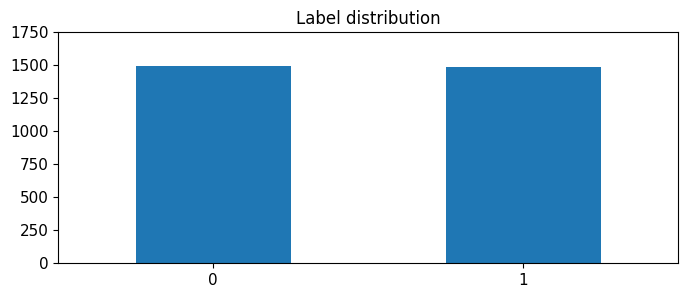

In [36]:
# plot barchart for df
print(df.label.value_counts())
df.label.value_counts().plot(kind = 'bar',
                                    title = 'Label distribution',
                                    ylim = [0, 1750],        
                                    rot = 0, fontsize = 11, figsize = (8,3))

1    505
0    495
Name: label, dtype: int64


<AxesSubplot: title={'center': 'Label distribution'}>

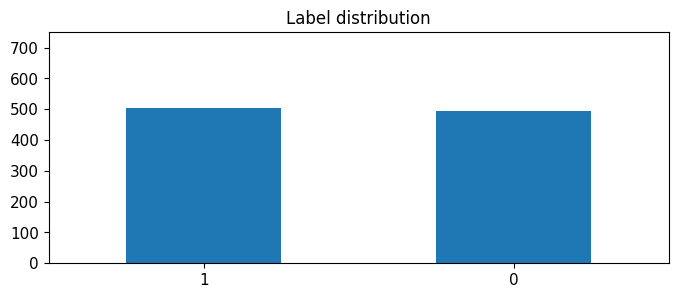

In [37]:
# plot barchart for df_sample
print(df_sample.label.value_counts())
df_sample.label.value_counts().plot(kind = 'bar',
                                    title = 'Label distribution',
                                    ylim = [0, 750],        
                                    rot = 0, fontsize = 11, figsize = (8,3))

#### Exercise 7

In [38]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


<AxesSubplot: title={'center': 'df_sample Label distribution'}>

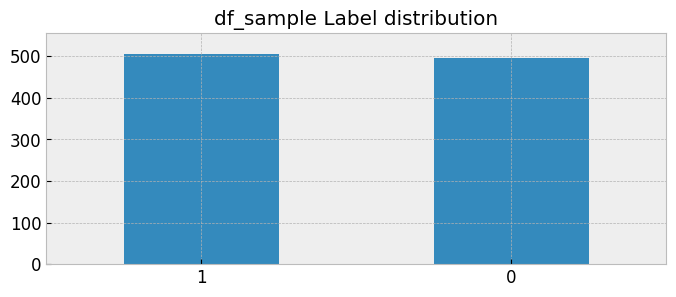

In [39]:
# Answer here

plt.style.use('bmh')

# plot barchart for X_sample
max = df_sample.label.value_counts().max()
# plot barchart for X_sample
df_sample.label.value_counts().plot(kind = 'bar',
                                           title = 'df_sample Label distribution',
                                           ylim = [0, max + 0.1*max], 
                                           rot = 0, fontsize = 12, figsize = (8,3))

#### Exercise 8

In [40]:
df

text label
0     So there is no way for me to plug it in here i...     0
1                           Good case, Excellent value.     1
2                                Great for the jawbone.     1
3     Tied to charger for conversations lasting more...     0
4                                     The mic is great.     1
...                                                 ...   ...
2995  I think food should have flavor and texture an...     0
2996                           Appetite instantly gone.     0
2997  Overall I was not impressed and would not go b...     0
2998  The whole experience was underwhelming, and I ...     0
2999  Then, as if I hadn't wasted enough of my life ...     0

[2983 rows x 2 columns]

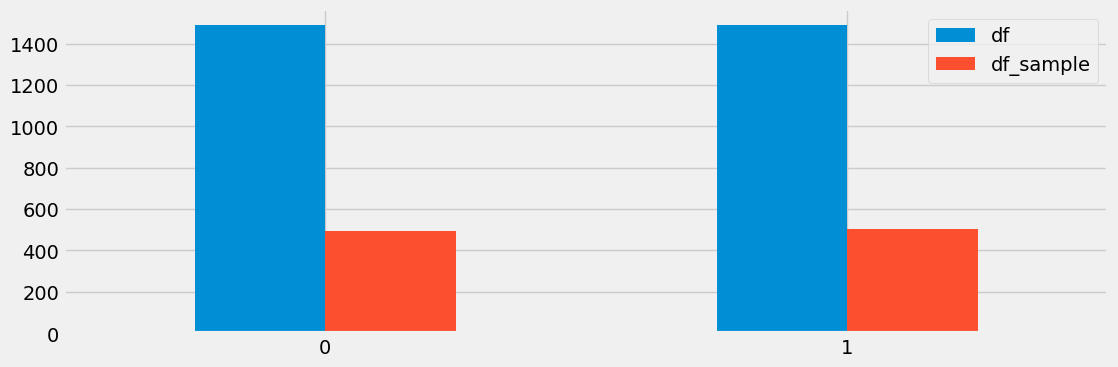

In [41]:
plt.style.use('fivethirtyeight')

a = df.label.value_counts()
b = df_sample.label.value_counts()
index = a.index.values.tolist()

g = pd.DataFrame({"df": a, "df_sample": b}, index=index)

ax = g.plot.bar(rot=0, figsize=(12, 4))

### 5.2 Feature Creation

In [42]:
df['unigrams'] = df['text'].apply(lambda x: dmh.tokenize_text(x))

In [43]:
df.head()['unigrams']

0    [So, there, is, no, way, for, me, to, plug, it...
1                 [Good, case, ,, Excellent, value, .]
2                        [Great, for, the, jawbone, .]
3    [Tied, to, charger, for, conversations, lastin...
4                             [The, mic, is, great, .]
Name: unigrams, dtype: object

In [44]:
df.head()

text label  \
0  So there is no way for me to plug it in here i...     0   
1                        Good case, Excellent value.     1   
2                             Great for the jawbone.     1   
3  Tied to charger for conversations lasting more...     0   
4                                  The mic is great.     1   

                                            unigrams  
0  [So, there, is, no, way, for, me, to, plug, it...  
1               [Good, case, ,, Excellent, value, .]  
2                      [Great, for, the, jawbone, .]  
3  [Tied, to, charger, for, conversations, lastin...  
4                           [The, mic, is, great, .]

### 5.3 Feature Subset Selection

In [45]:
count_vect = CountVectorizer()
df_counts = count_vect.fit_transform(df.text) #learn the vocabulary and return document-term matrix
print(df_counts[0])

  (0, 4161)	1
  (0, 4545)	1
  (0, 2427)	1
  (0, 3043)	1
  (0, 4987)	1
  (0, 1829)	1
  (0, 2809)	1
  (0, 4609)	1
  (0, 3387)	1
  (0, 2432)	1
  (0, 2314)	2
  (0, 2158)	1
  (0, 4531)	1
  (0, 4835)	1
  (0, 4793)	1
  (0, 1982)	1
  (0, 647)	1
  (0, 1013)	1


#### Exercise 9

In [46]:
analyze = count_vect.build_analyzer()
analyze(df.text[0])

['so',
 'there',
 'is',
 'no',
 'way',
 'for',
 'me',
 'to',
 'plug',
 'it',
 'in',
 'here',
 'in',
 'the',
 'us',
 'unless',
 'go',
 'by',
 'converter']

In [47]:
df_counts.shape

(2983, 5155)

In [48]:
count_vect.get_feature_names_out()[0:10]

array(['00', '10', '100', '11', '12', '13', '15', '15g', '15pm', '17'],
      dtype=object)

In [49]:
df_counts[:100]

<100x5155 sparse matrix of type '<class 'numpy.int64'>'
	with 922 stored elements in Compressed Sparse Row format>

In [50]:
df_counts[:5, :100].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

In [51]:
count_vect.get_feature_names_out()[0:1]

array(['00'], dtype=object)

#### Exercise 10

Since there is no second 1 in above array, so I print out the first 1 that I saw in above array, whice is in the index 3 - record.

In [52]:
feature_name = count_vect.get_feature_names_out()[0:100]
a = df_counts[3, 0:100].toarray()
ones = np.where(a == 1)
feature_name[ones[1][0]]

'45'

In [53]:
# Since there is no first 20 features in first 20 documents, so I change it to 40 ~ 60.

# first twenty features only
plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()[40:60]]
# obtain document index
plot_y = ["doc_"+ str(i) for i in list(df.index)[0:20]]

plot_z = df_counts[0:20, 40:60].toarray()
plot_z

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

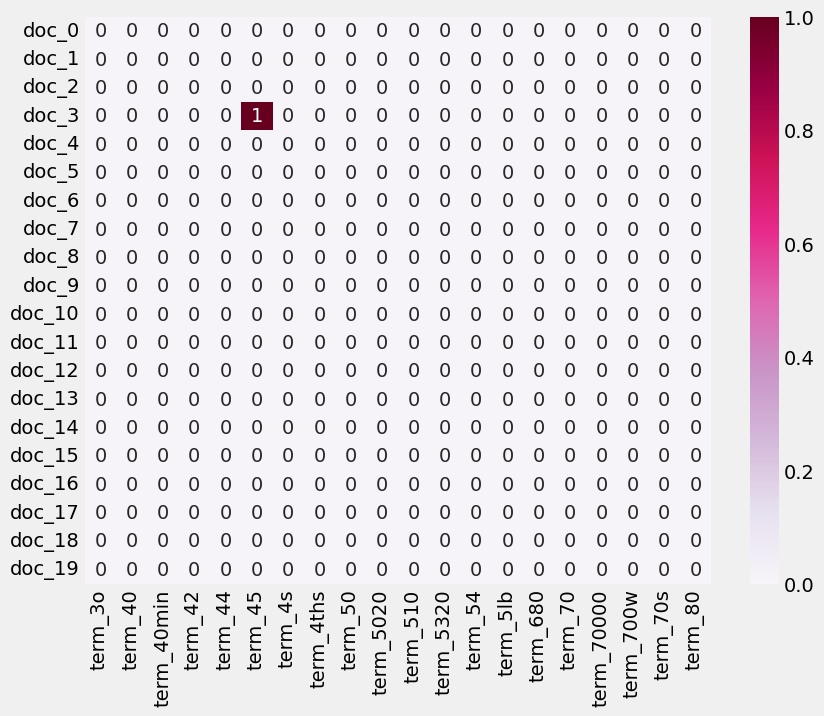

In [54]:
df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(9, 7))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd",
                 vmin=0, vmax=1, annot=True)

#### Exercise 11
Since this term-document matrix is too sparse to draw the heatmap, I will use the scatter plot to visualize it. There are two reasons that it does not suitable for heatmap. One is there will be too many 0 and the graph will be messy. Second is there are only 2 values in the matrix so we don't need the color to clarify different scale of it. The scatter plot would be better because we can see 1 as a point, and 0 as nothing.

Text(0, 0.5, 'document id')

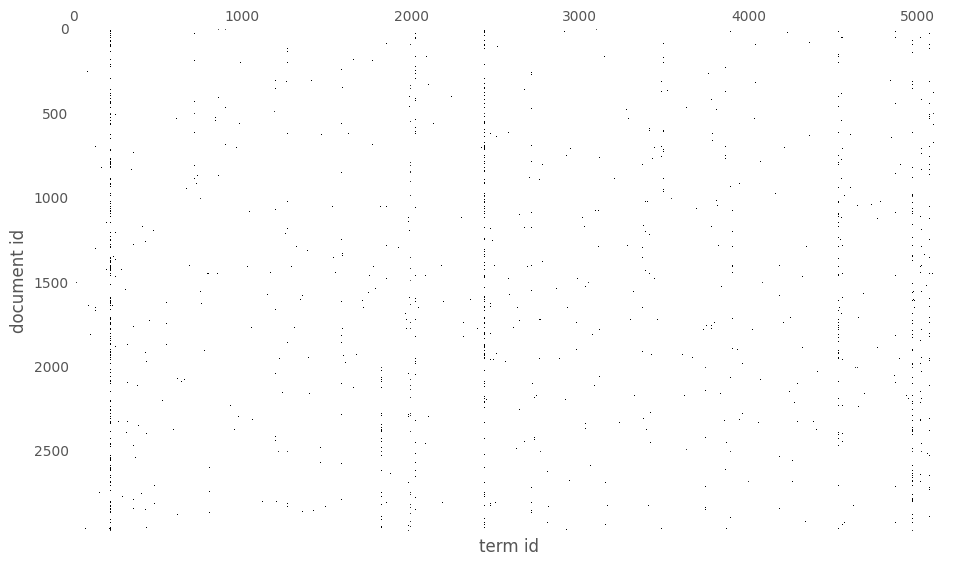

In [55]:
# Or we can use a scatter point for visualization
plt.style.use('ggplot')

plot_x = ["term_"+str(i) for i in count_vect.get_feature_names_out()]
plot_y = ["doc_"+ str(i) for i in list(df.index)]
plot_z = df_counts.toarray()
df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(10, 10))
plt.spy(df_todraw)
plt.xlabel("term id")
plt.ylabel("document id")

### 5.4 Dimensionality Reduction

In [56]:
df_reduced = PCA(n_components = 2).fit_transform(df_counts.toarray())
df_reduced.shape

(2983, 2)

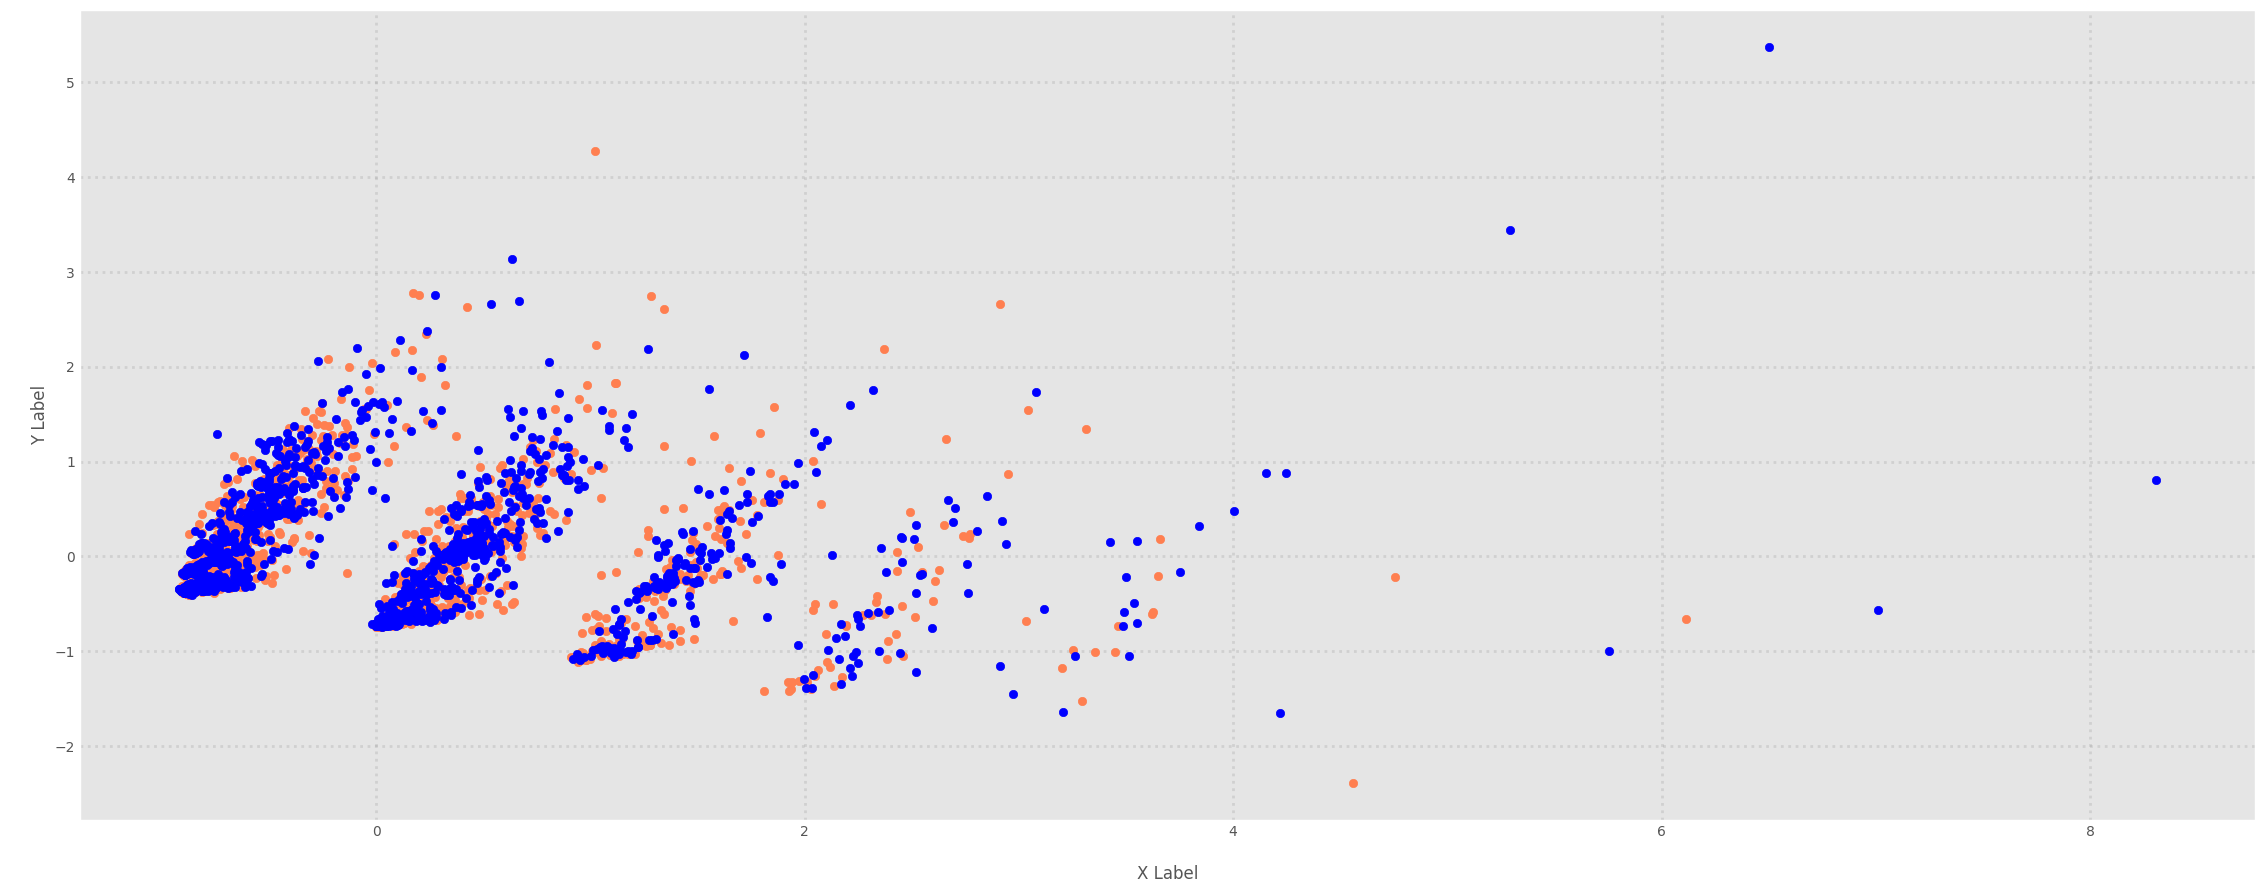

In [57]:
col = ['coral', 'blue']
labels = [0, 1]

plt.style.use('ggplot')

# plot
fig = plt.figure(figsize = (25,10))
ax = fig.subplots()

for c, label in zip(col, labels):
    xs = df_reduced[df['label'] == label].T[0]
    ys = df_reduced[df['label'] == label].T[1]
   
    ax.scatter(xs, ys, c=c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')

plt.show()

#### Exercise 12

It seems that those documents would be cluster into 4 groups, observing by 2-component PCA and the first graph of 3-component PCA. But the cluster is not related to the label, they are almost aggregated together. Therefore, maybe at here it is not a good way to use PCA 3d to classify these documents.

In [58]:
df_reduced = PCA(n_components = 3).fit_transform(df_counts.toarray())
print(df_reduced.shape)

(2983, 3)


Origin view point


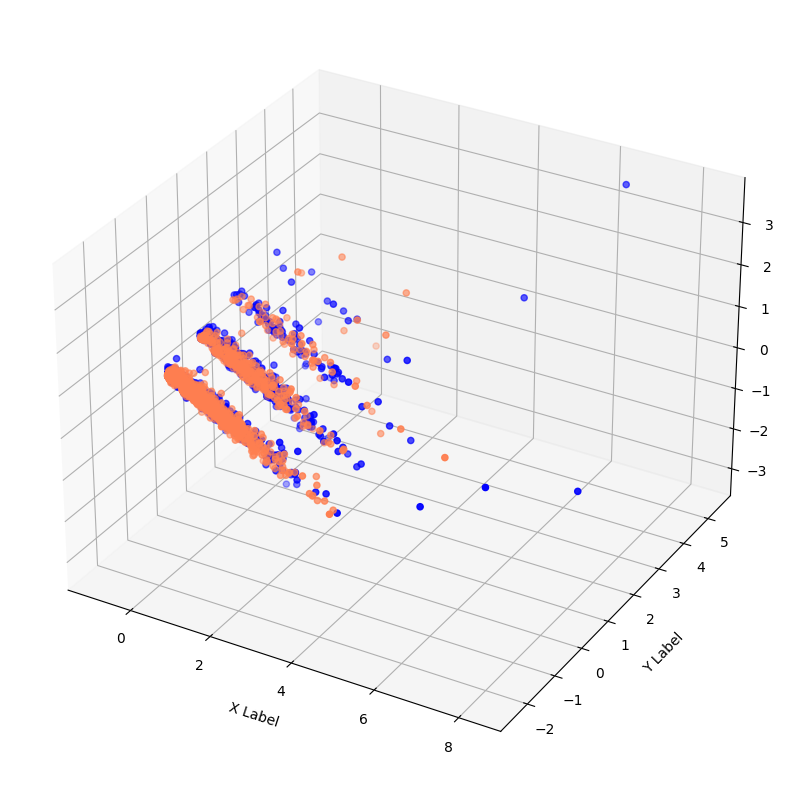

In [59]:
plt.style.use('default')

plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

for c, label in zip(col, labels):
    data = df_reduced[df['label'] == label].T
    xs = data[0]
    ys = data[1]
    zs = data[2]
   
    ax.scatter3D(xs, ys, zs, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')
ax.set_zlabel('\nZ Label')

print("Origin view point")

plt.show()

View point: elev=20, azim=45, roll=5


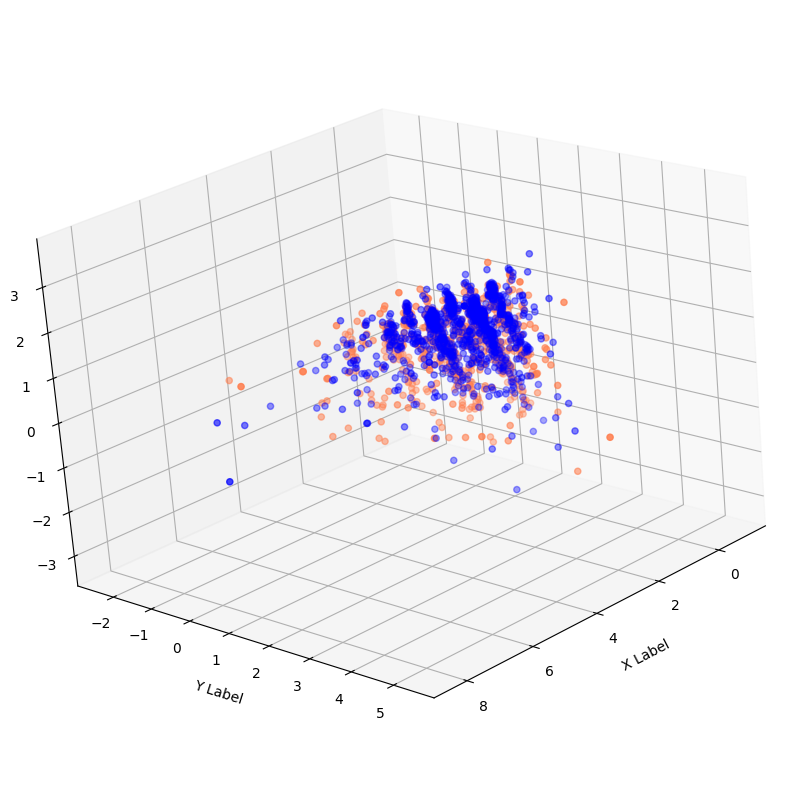

In [60]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

for c, label in zip(col, labels):
    data = df_reduced[df['label'] == label].T
    xs = data[0]
    ys = data[1]
    zs = data[2]
   
    ax.scatter3D(xs, ys, zs, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')
ax.set_zlabel('\nZ Label')

ax.view_init(elev=20, azim=45, roll=5)
print("View point: elev=20, azim=45, roll=5")

plt.show()

View point: elev=0, azim=10


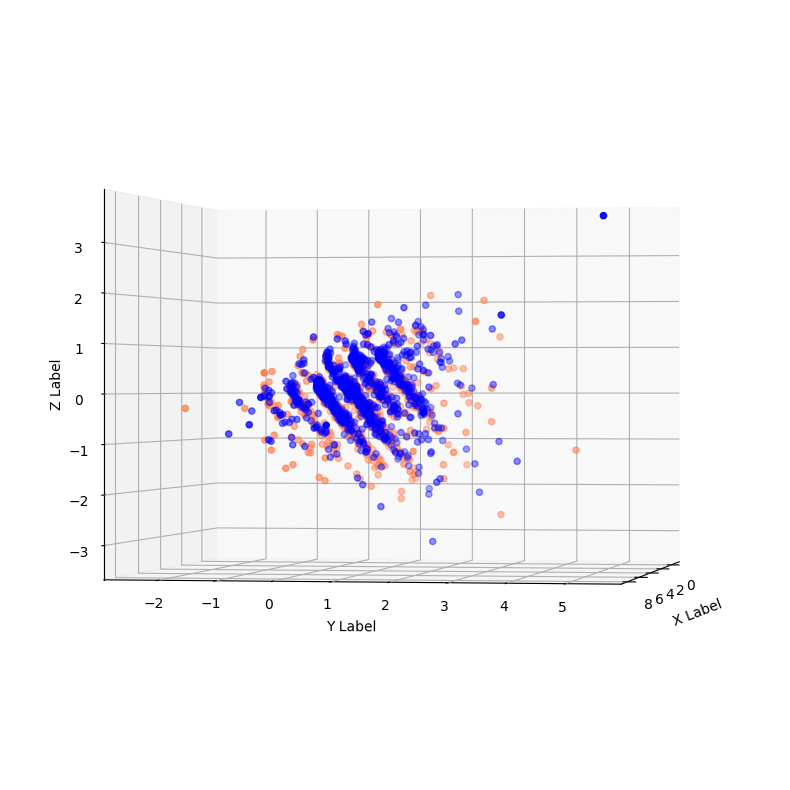

In [61]:
plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')

for c, label in zip(col, labels):
    data = df_reduced[df['label'] == label].T
    xs = data[0]
    ys = data[1]
    zs = data[2]
   
    ax.scatter3D(xs, ys, zs, c = c, marker='o')

ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')
ax.set_zlabel('\nZ Label')

ax.view_init(elev=0, azim=10)
print("View point: elev=0, azim=10")

plt.show()

### 5.5 Atrribute Transformation / Aggregation

In [62]:
term_frequencies = []
for j in range(0,df_counts.shape[1]):
    term_frequencies.append(sum(df_counts[:,j].toarray()))

In [63]:
df_counts

<2983x5155 sparse matrix of type '<class 'numpy.int64'>'
	with 31515 stored elements in Compressed Sparse Row format>

In [64]:
term_frequencies = np.asarray(df_counts.sum(axis=0))[0]

In [65]:
len(term_frequencies)

5155

In [66]:
term_frequencies[0] # sum of the first term

1

0.809528112411499  sec


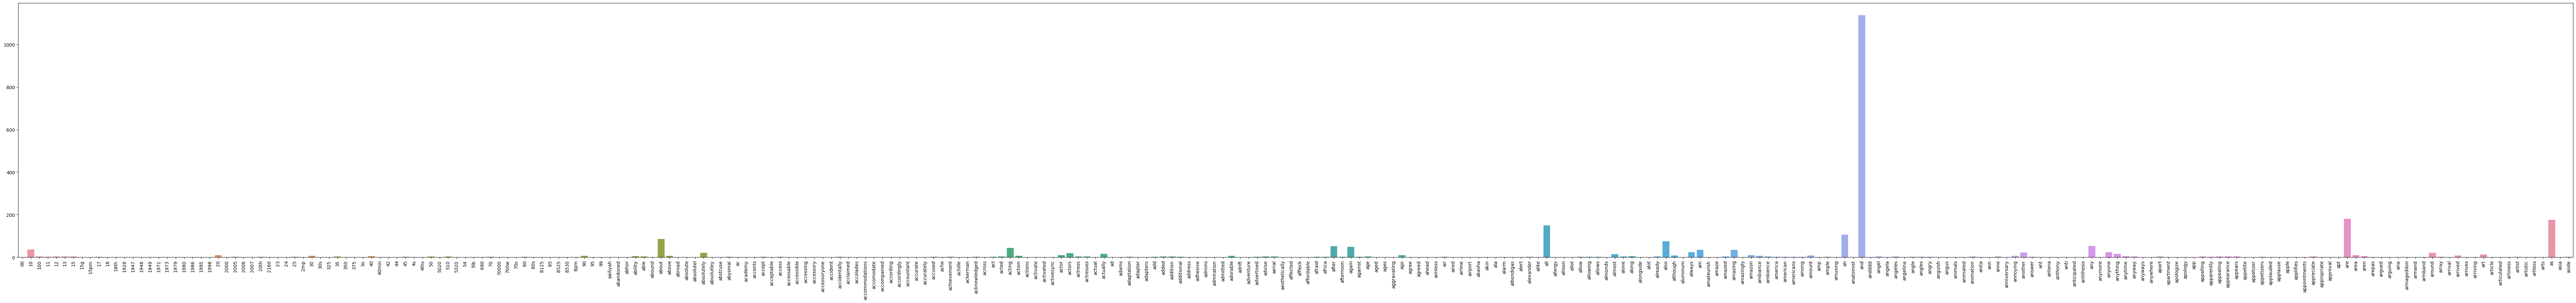

In [67]:
start = time.time()
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300], 
            y=term_frequencies[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);
end = time.time()
print(end - start, " sec")

#### Exercise 13

Visualize the grpah using plotly funciton

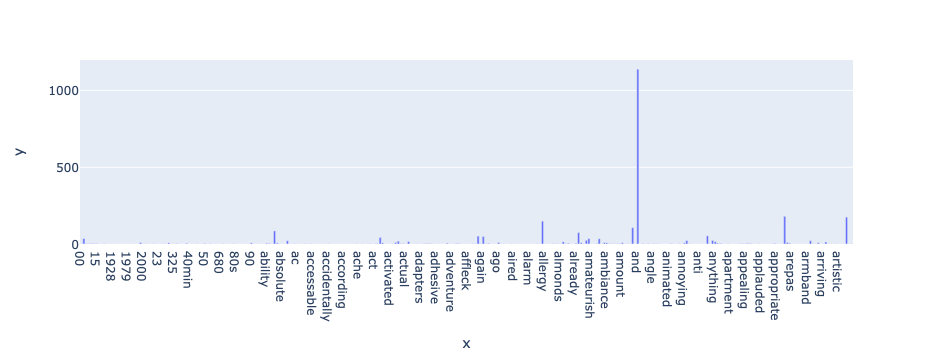

0.36067914962768555  sec


In [68]:
# Answer here
start = time.time()
fig = px.bar(x=count_vect.get_feature_names_out()[:300], y=term_frequencies[:300])
fig.show()
end = time.time()
print(end - start, " sec")

#### Exercise 14

In [69]:
# Just select the word that appear more than once
np.where(term_frequencies > 1)[0].shape

(2235,)

In [70]:
# Just select the word that appear more than 10
np.where(term_frequencies > 10)[0].shape

(424,)

(97,)


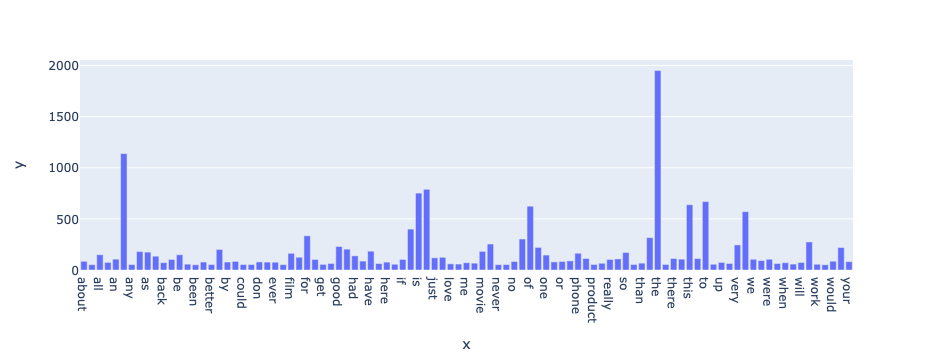

0.04160499572753906  sec


In [71]:
# Just select the word that appear more than 50
index = np.where(term_frequencies > 50)[0]
print(index.shape)

start = time.time()
tf_temp = term_frequencies[index]
fn_temp = count_vect.get_feature_names_out()[index]
fig = px.bar(x=fn_temp, y=tf_temp)
fig.show()
end = time.time()
print(end - start, " sec")

In [87]:
# Or you can choose the number of terms and where the term id start to visualize

# Default we visualize first 100 terms
def vis_term(num=100, start=0):
    tf_temp = term_frequencies[start:start+num]
    fn_temp = count_vect.get_feature_names_out()[start:start+num]
    fig = px.bar(x=fn_temp, y=tf_temp)
    fig.show()

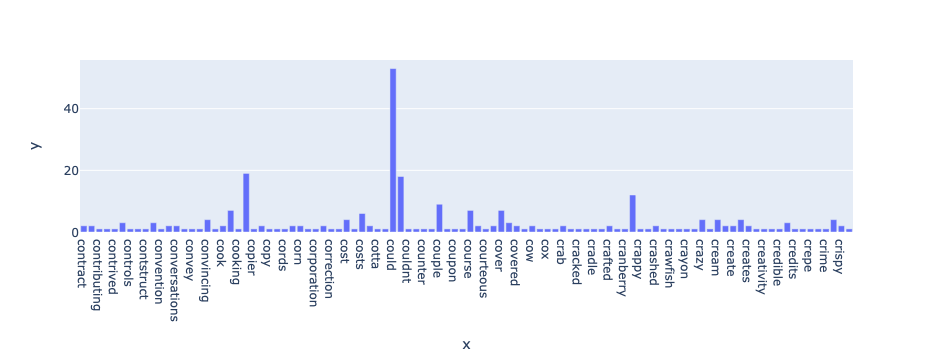

In [88]:
vis_term(start=1000)

#### Exercise 15

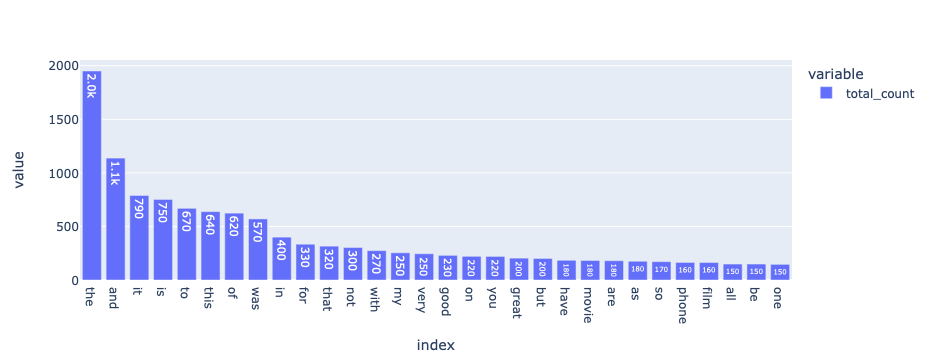

In [72]:
# Answer here

# We may want to know what is the most frequent word in document, 
# so first we make a dataframe that sort by total_count of all terms
td = pd.DataFrame(df_counts.toarray())
td.columns = count_vect.get_feature_names_out()
tdm = td.T
tdm.columns = ['doc_' + str(i) for i in range(df_counts.shape[0])]
tdm['total_count'] = tdm.sum(axis=1)
tdm = tdm.sort_values(by='total_count', ascending=False)
tfs = tdm['total_count']


# Then we plot the top 30 frequent terms in bar plot
fig = px.bar(tfs[:30], text_auto='.2s')
fig.show()

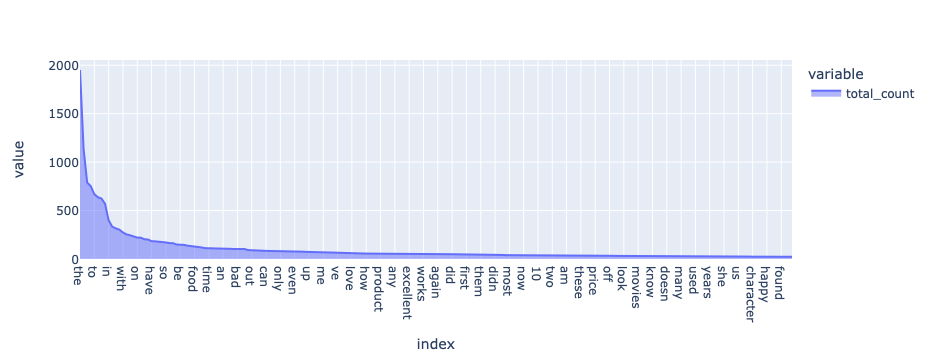

In [73]:
# Or we can plot the line graph with filling color in are
fig = px.area(tfs[:200])
fig.show()

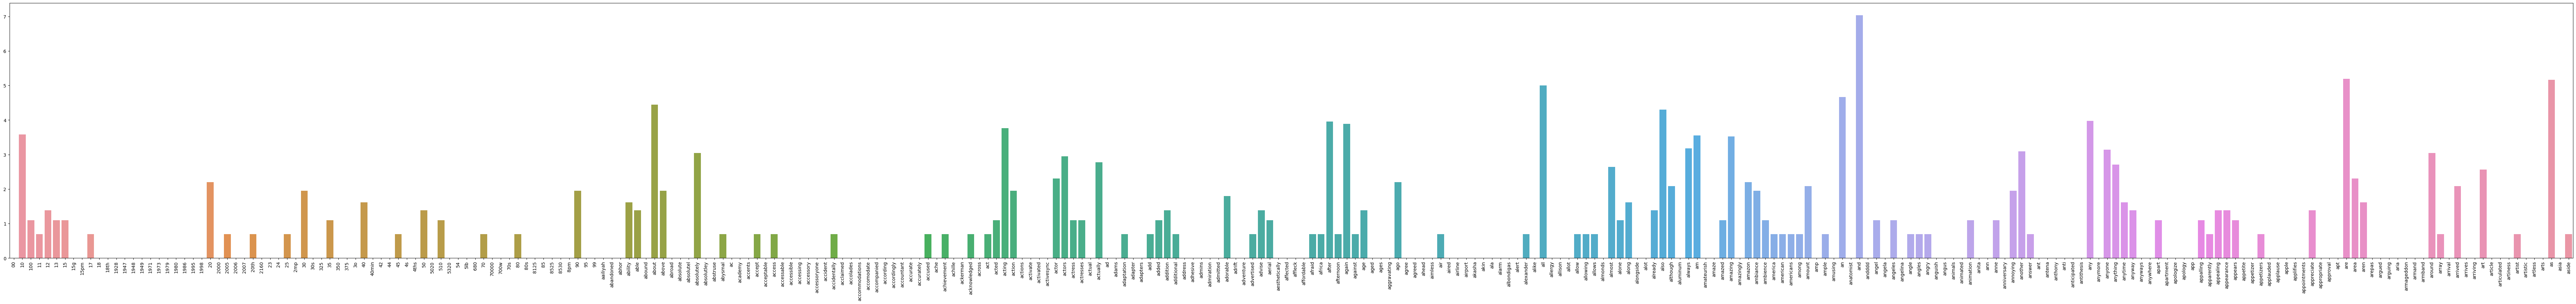

In [74]:
term_frequencies_log = [math.log(i) for i in term_frequencies]
plt.subplots(figsize=(100, 10))
g = sns.barplot(x=count_vect.get_feature_names_out()[:300],
                y=term_frequencies_log[:300])
g.set_xticklabels(count_vect.get_feature_names_out()[:300], rotation = 90);

### 5.6 Discretization and Binarization

In [75]:
df

text label  \
0     So there is no way for me to plug it in here i...     0   
1                           Good case, Excellent value.     1   
2                                Great for the jawbone.     1   
3     Tied to charger for conversations lasting more...     0   
4                                     The mic is great.     1   
...                                                 ...   ...   
2995  I think food should have flavor and texture an...     0   
2996                           Appetite instantly gone.     0   
2997  Overall I was not impressed and would not go b...     0   
2998  The whole experience was underwhelming, and I ...     0   
2999  Then, as if I hadn't wasted enough of my life ...     0   

                                               unigrams  
0     [So, there, is, no, way, for, me, to, plug, it...  
1                  [Good, case, ,, Excellent, value, .]  
2                         [Great, for, the, jawbone, .]  
3     [Tied, to, charger, for, conversations, lastin...  
4                              [The, mic, is, great, .]  
...                                                 ...  
2995  [I, think, food, should, have, flavor, and, te...  
2996                     [Appetite, instantly, gone, .]  
2997  [Overall, I, was, not, impressed, and, would, ...  
2998  [The, whole, experience, was, underwhelming, ,...  
2999  [Then, ,, as, if, I, had, n't, wasted, enough,...  

[2983 rows x 3 columns]

In [76]:
# Since the original data type of the column are all objects, it can not be fit
# into LabelBinarizer, so I turn label into int, text into string.
print(df.dtypes)
df.label = df.label.astype('int64')
df.text = df.text.astype('string')
print("----\n", df.dtypes)

text        object
label       object
unigrams    object
dtype: object
----
 text        string
label        int64
unigrams    object
dtype: object


In [77]:
mlb = preprocessing.LabelBinarizer()
moh = preprocessing.OneHotEncoder()

In [78]:
mlb.fit(df.label)

LabelBinarizer()

In [79]:
df['bin_label'] = mlb.transform(df['label']).tolist()

In [80]:
df.head()

text  label  \
0  So there is no way for me to plug it in here i...      0   
1                        Good case, Excellent value.      1   
2                             Great for the jawbone.      1   
3  Tied to charger for conversations lasting more...      0   
4                                  The mic is great.      1   

                                            unigrams bin_label  
0  [So, there, is, no, way, for, me, to, plug, it...       [0]  
1               [Good, case, ,, Excellent, value, .]       [1]  
2                      [Great, for, the, jawbone, .]       [1]  
3  [Tied, to, charger, for, conversations, lastin...       [0]  
4                           [The, mic, is, great, .]       [1]

#### Exercise 16

Since there is only one label column, so I can't transform any other to the binarized type.

## 6. Data Exploration

In [81]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = df.iloc[50]
random_record_1 = random_record_1['text']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = df.iloc[100]
random_record_2 = random_record_2['text']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = df.iloc[150]
random_record_3 = random_record_3['text']
document_to_transform_3.append(random_record_3)

In [82]:
print(document_to_transform_1)
print(document_to_transform_2)
print(document_to_transform_3)

["Not loud enough and doesn't turn on like it should."]
['Integrated seamlessly with the Motorola RAZR phone.']
['I Was Hoping for More.']


In [83]:
# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [84]:

# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print 
print("Cosine Similarity using count bw 1 and 2: %(x)f" %{"x":cos_sim_count_1_2})
print("Cosine Similarity using count bw 1 and 3: %(x)f" %{"x":cos_sim_count_1_3})
print("Cosine Similarity using count bw 2 and 3: %(x)f" %{"x":cos_sim_count_2_3})

print("Cosine Similarity using count bw 1 and 1: %(x)f" %{"x":cos_sim_count_1_1})
print("Cosine Similarity using count bw 2 and 2: %(x)f" %{"x":cos_sim_count_2_2})
print("Cosine Similarity using count bw 3 and 3: %(x)f" %{"x":cos_sim_count_3_3})

Cosine Similarity using count bw 1 and 2: 0.000000
Cosine Similarity using count bw 1 and 3: 0.000000
Cosine Similarity using count bw 2 and 3: 0.000000
Cosine Similarity using count bw 1 and 1: 1.000000
Cosine Similarity using count bw 2 and 2: 1.000000
Cosine Similarity using count bw 3 and 3: 1.000000
